This notebook looks at the "vote decay" of users. The New Yorker caption contest organizer, Bob Mankoff, has received many emails like the one below (name/personal details left out for anonymity)

> Here's my issue. 

> First time I encounter something, I might say it's funny. 

> Then it comes back in many forms over and over and it's no longer funny and I wish I could go back to the first one and say it's not funny. 

> But it's funny, and then I can't decide whether to credit everyone with funny or keep hitting unfunny. What I really like to find out is who submitted it first, but often it's slightly different and there may be a best version. Auggh!

> How should we do this???

We can investigate this: we have all the data at hand. We record the timestamp, participant ID and their rating for a given caption. So let's see how votes go after a user has seen $n$ captions!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Reading in data
Let's read in the data. As the last column can contain a non-escaped comma, we have to fix that before doing any analysis.

Note that two versions of this notebook exist (the previous notebook can be found in [43bc5d]). This highlights some of the differences required to read in the earlier datasets.

[43bc5d]:https://github.com/nextml/caption-contest-data/commit/43bc5d23ee287b8b34cc4eb0181484bd21bbd341

In [2]:
contest = '540'
responses = pd.read_csv('../contests/passive/{}/participant_responses_RandomSampling.csv'.format(contest))
responses.head()

,Unnamed: 0,Partipipant ID,Response Time (s),Network Delay (s),Timestamp,Rating,Alg label,Target
0,0,EVjkeVAE4xZhKuuHqjs5,2.454,0.217389,2016-10-12 19:40:41.252634,1.0,RandomSampling,My last doctor was in it just for the money.
1,1,EVjkeVAE4xZhKuuHqjs5,1.185,0.114715,2016-10-12 19:40:43.990988,1.0,RandomSampling,"It's a combination of 2s, 4s, and definitely s..."
2,2,EVjkeVAE4xZhKuuHqjs5,1.132,0.119777,2016-10-12 19:40:45.371481,1.0,RandomSampling,I don't hear a thing. Maybe it all really did ...
3,3,EVjkeVAE4xZhKuuHqjs5,0.710,0.124947,2016-10-12 19:40:46.679399,1.0,RandomSampling,You should really lose some weight.
4,4,EVjkeVAE4xZhKuuHqjs5,0.881,0.119091,2016-10-12 19:40:47.578273,1.0,RandomSampling,"Money talks: ""You say you're feeling claustrop..."


## Seeing how many captions a user has seen
This is the workhorse of the notebook: it sees how many captions one participant has seen. I sorted by timestamp (and with an actual timestamp, not a str) to collect the ratings in the order a user has seen. I do not assume that only one user answers at a time.

In [3]:
last_id = None
i = 0
num_responses = []
captions_seen = []
responses = responses.sort_values(by='Timestamp')
# responses = responses[0:1000]  # debug

In [4]:
captions_seen_by = {}
captions_seen = []
for _, response in responses.iterrows():
    id_, rating = response['Partipipant ID'], response['Rating']
    if id_ not in captions_seen_by:
        captions_seen_by[id_] = 0
    captions_seen_by[id_] += 1
    captions_seen += [captions_seen_by[id_]]
    num_responses += [i]

In [5]:
responses['number of captions seen'] = captions_seen
responses.head()

,Unnamed: 0,Partipipant ID,Response Time (s),Network Delay (s),Timestamp,Rating,Alg label,Target,number of captions seen
234872,234872,EKjDKfTX9LNM2MThReJC,4.557,0.071828,2016-10-10 17:21:45.573372,1.0,RandomSampling,You probably wouldn't even be here if you had ...,1
234873,234873,EKjDKfTX9LNM2MThReJC,14.824,0.076773,2016-10-10 17:21:50.381564,1.0,RandomSampling,I guess I don't need to apologize for my cold ...,2
234874,234874,EKjDKfTX9LNM2MThReJC,4.752,0.142236,2016-10-10 17:22:05.504520,1.0,RandomSampling,"I'm sorry but your tumblers are dry, your pett...",3
234875,234875,EKjDKfTX9LNM2MThReJC,3.380,0.070380,2016-10-10 17:22:10.584019,1.0,RandomSampling,New and improved provider reimbursement under ...,4
234876,234876,EKjDKfTX9LNM2MThReJC,2.258,0.068067,2016-10-10 17:22:14.221277,1.0,RandomSampling,Try a more balanced diet . . . your acid test ...,5


## Viewing the data
Now let's format the data to view it. We can view the data in two ways: as we only have three rating values, we can view the probability of a person rating 1, 2 or 3, and can also view the mean.

In this, we rely on `pd.pivot_table`. This can take DataFrame that looks like a list of dictionaries and compute `aggfunc` (by default `np.mean`) for all items that contain common keys (indicated by `index` and `columns`). It's similar to Excel's pivot table functionality.

### Probability of rating {1, 2, 3}

In [6]:
def prob(x):
    n = len(x)
    ret = {'n': n}
    ret.update({name: np.sum(x == i) for name, i in [('unfunny', 1),
                                                  ('somewhat funny', 2),
                                                  ('funny', 3)]})
    return ret

probs = responses.pivot_table(index='number of captions seen',
                              columns='Alg label', values='Rating',
                              aggfunc=prob)
probs.head()

Alg label,RandomSampling
number of captions seen,
1,"{'n': 8076, 'funny': 711, 'somewhat funny': 22..."
2,"{'n': 7663, 'funny': 537, 'somewhat funny': 18..."
3,"{'n': 7390, 'funny': 576, 'somewhat funny': 16..."
4,"{'n': 7142, 'funny': 516, 'somewhat funny': 15..."
5,"{'n': 6915, 'funny': 554, 'somewhat funny': 13..."


In [7]:
d = {label: dict(probs[label]) for label in ['RandomSampling']}
for label in d.keys():
    for n in d[label].keys():
        if d[label][n] is None:
            continue
        for rating in ['unfunny', 'somewhat funny', 'funny']:
            d[label][n][rating] = d[label][n][rating] / d[label][n]['n']

In [8]:
df = pd.DataFrame(d['RandomSampling']).T
df = pd.concat({'RandomSampling': df}, axis=1)
df.head()

RandomSampling                                 
           funny       n somewhat funny   unfunny
1       0.088039  8076.0       0.273774  0.638187
2       0.070077  7663.0       0.235808  0.694115
3       0.077943  7390.0       0.217321  0.704736
4       0.072249  7142.0       0.221367  0.706385
5       0.080116  6915.0       0.201446  0.718438

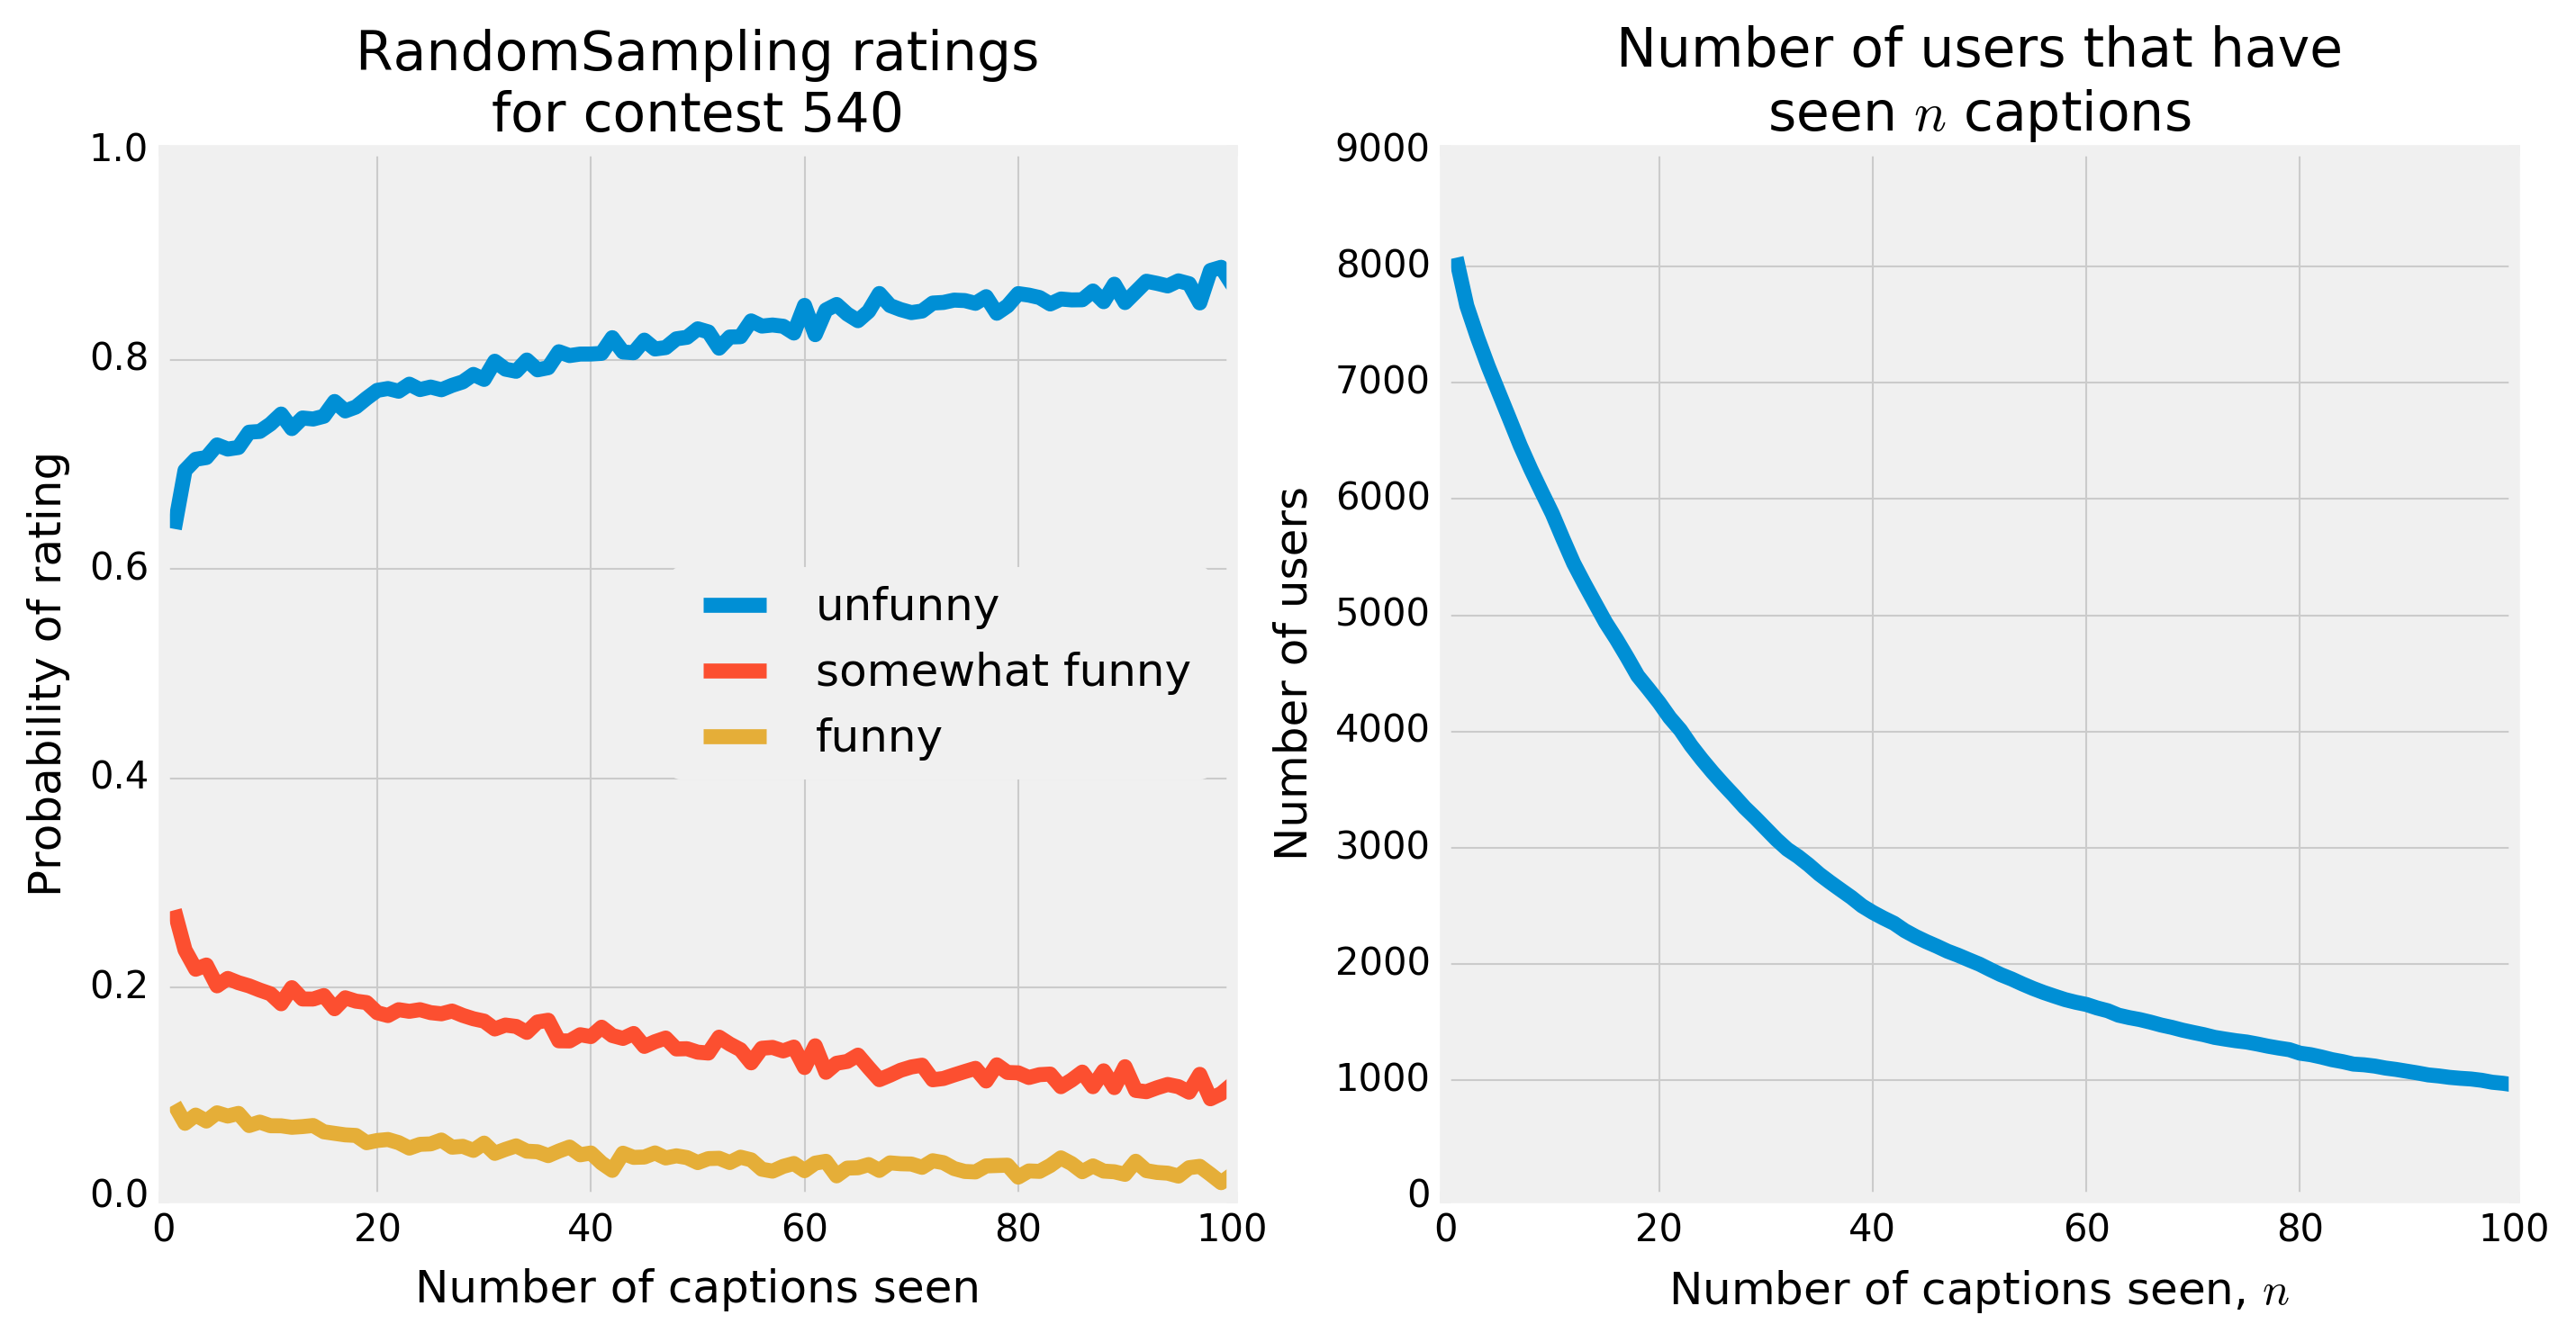

In [13]:
def plot(alg):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(1, 2, 1)
    df[alg][['unfunny', 'somewhat funny', 'funny']].plot(ax=ax)
    plt.xlim(0, 100)
    plt.title('{} ratings\nfor contest {}'.format(alg, contest))
    plt.ylabel('Probability of rating')
    plt.xlabel('Number of captions seen')

    ax = plt.subplot(1, 2, 2)
    df[alg]['n'].plot(ax=ax, logy=False)
    plt.ylabel('Number of users')
    plt.xlabel('Number of captions seen, $n$')
    plt.title('Number of users that have\nseen $n$ captions')
    plt.xlim(0, 100)
    
for alg in ['RandomSampling']:
    fig = plot(alg)
    plt.show()

### Average rating

In [14]:
center = responses.pivot_table(index='number of captions seen', columns='Alg label', values='Rating')
std = responses.pivot_table(index='number of captions seen',
                            columns='Alg label', values='Rating', aggfunc=np.std)

In [23]:
center.head()

Alg label,RandomSampling
number of captions seen,
1,1.449851
2,1.375962
3,1.373207
4,1.365864
5,1.361678


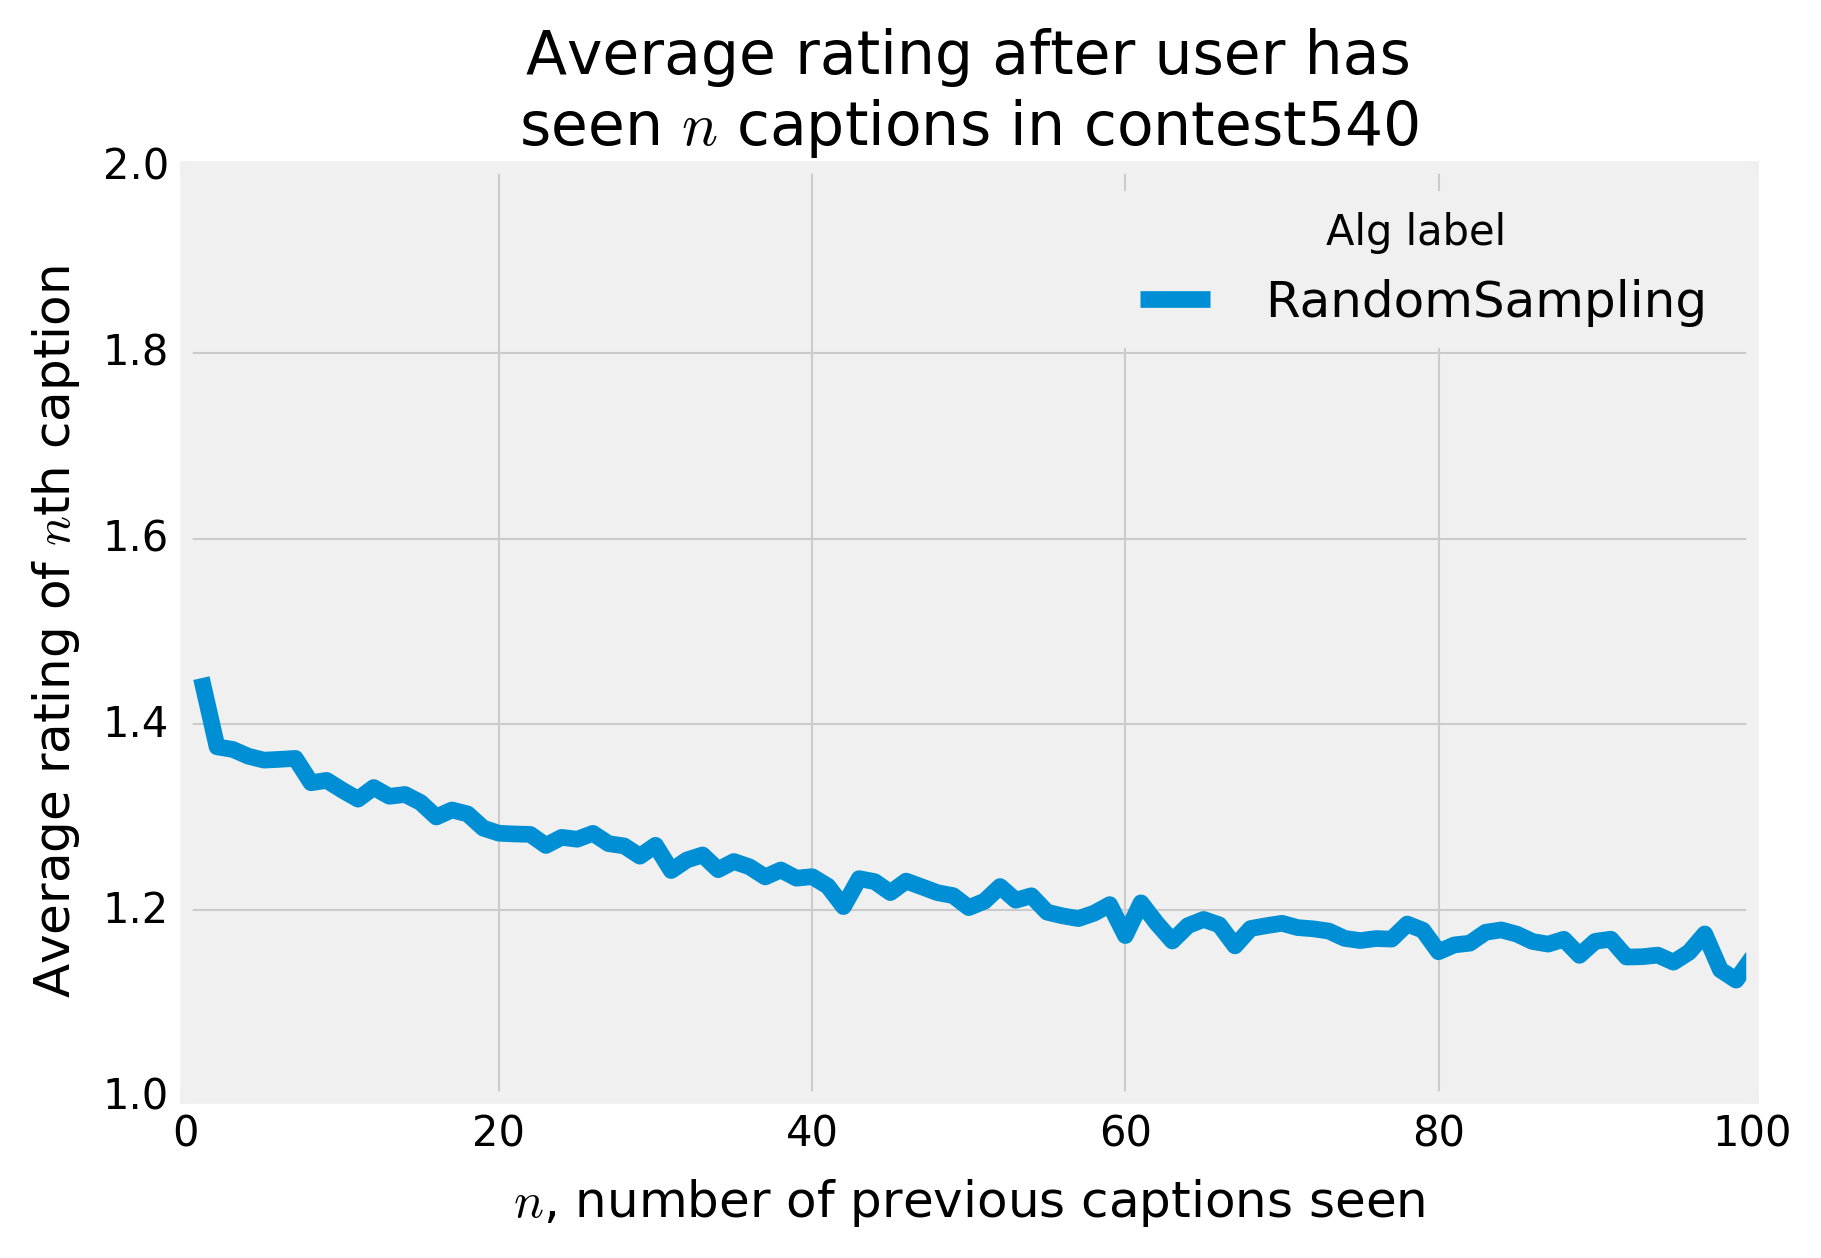

In [28]:
plt.figure()
center.plot()#, yerr=std)
plt.xlim(0, 100)
plt.ylim(1.0, 2.0)
plt.ylabel('Average rating of $n$th caption')
plt.xlabel('$n$, number of previous captions seen')
plt.title('Average rating after user has\nseen $n$ captions in contest{}'.format(contest))
plt.show()